In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sc
import h5py as h5
import os.path
import matplotlib.ticker
from matplotlib import cm

from numba import jit, njit, prange

plt.rc('figure', figsize=(12, 9))
plt.rcParams.update({'text.usetex': True,
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 20,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.width': 1.7,
                     'ytick.major.width': 1.7,
                     'xtick.major.size': 7.,
                     'ytick.major.size': 7.,
                     'ytick.right':True, 
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': False,
                     'grid.alpha': 0.5,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 17,
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.bbox': 'tight',
                     'savefig.pad_inches': 0.05,
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

from src.constants import *
from src import waveform as wave

In [2]:
# masses in SI
M1, M2 = 1.35*Ms, 1.35*Ms
# radii in [m]
R1, R2 = 11.7e3, 11.7e3

rM1 = G*M1/c**2
rM2 = G*M2/c**2
tMt = G*(M1+M2)/c**3.


# inputs to the GW waveform generation code
# most of the variables' names should be self-explanatory
# also see waveform.get_hDL_M_modes_vs_t for detailed explanation 
kwargs = {
    'dt':1/2**15,
    'mass1':M1/Ms,
    'mass2':M1/Ms,
    'spin1z':-0.2, # physical background spin rate is -390 Hz
    'spin2z':0,
    'r_M_init': 18., 
    'phi_init':0,
    'iota':np.pi/2., 
    'R1_M1':R1/rM1,
    'I1_M1_3':12.34,
    'lam1_l2_M1_5':389.,
    'lam1_l3_M1_7':700.,
    'M1wa01_l2':0.07934,
    'M1wa01_l3':0.1067,
    'C1_l2':-0.25,
    'C1_l3':-1./3,
    'll1':np.array([2, 2, 2, 3, 3]), # this specifies the list of NS modes to be evolved; not GW modes!
    'mm1':np.array([2, 0, -2, 3, -3]), # this specifies the list of NS modes to be evolved; not GW modes!
    'Ces1':6,
    'R2_M2':R2/rM2,
    'I2_M2_3':12.34,
    'lam2_l2_M2_5':389., # 0 for NSBH 
    'lam2_l3_M2_7':700., # 0 for NSBH
    'M2wa02_l2':0.07934,
    'M2wa02_l3':0.1067,
    'C2_l2':-0.25,
    'C2_l3':-1./3,
    'll2':np.array([2, 2, 2, 3, 3]),
    'mm2':np.array([2, 0, -2, 3, -3]),
    'Ces2':6,
    'atol':1e-8,
    'rtol':1e-8,
    'order':4,
    'dlogvar':2e-4,
}



# For NSBH systems, please set lam2_l2_M2_5 = lam2_l3_M2_7 = 0 to zero the tide and Ces2 = 1
# Please keep R2 finite 
# (R2 >~ 3 M2 as it is used to terminate the evolution at r=R1+R2; this code cannot be used to evolve beyond the light ring)








# main code generating waveforms under the new EOB model
# hDL_M_modes has a shape of [n_times, 5]
# the last dim corresponds to (l, m) = (2,2), (2, 1), (3, 3), (3, 2), (4, 4) GW modes
tt, hDL_M_modes = wave.get_hDL_M_modes_vs_t(**kwargs)


# as a reference, also show waveforms generated under effective Love number approach 
# (by zeroing the tidal spin in back-reactions)
tt2, hDL_M_modes2= wave.get_hDL_M_modes_no_tspin_vs_t(**kwargs)

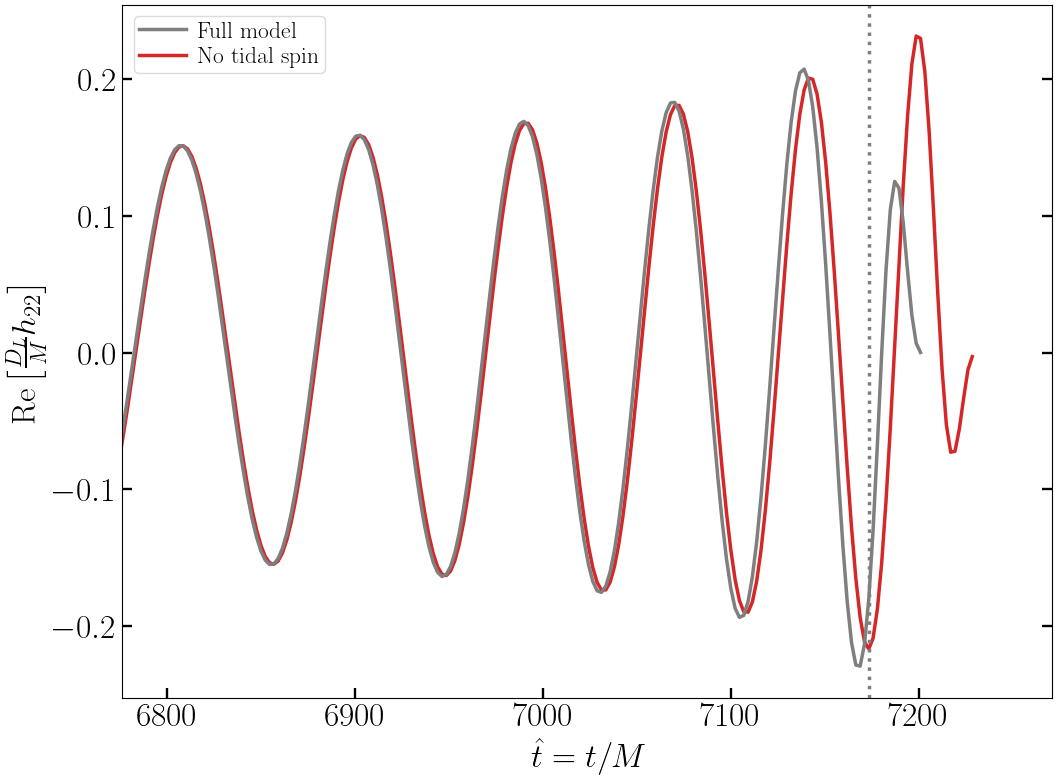

In [3]:
# plot the (2, 2) GW modes
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(tt/tMt, np.real(hDL_M_modes[0, :]), color='C7', label=r'Full model', zorder=2)
ax.plot(tt2/tMt, np.real(hDL_M_modes2[0, :]), color='C3', label=r'No tidal spin', zorder=1)

idx_pk = np.argmax(np.abs(hDL_M_modes[0, :]))

ax.axvline(tt[idx_pk]/tMt, color='C7', ls=':')

ax.set_xlim([tt[-1]/tMt-425, tt[-1]/tMt+70])
ax.set_ylabel(r'$ {\rm Re}\left[\frac{D_L}{M}h_{22}\right]$')
ax.set_xlabel(r'$\hat{t}=t/M$')
ax.legend(loc='upper left')